# EDA 

This is a draft of our team's EDA.

In [1]:
# import packages (write a script to import all of these at once later)
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
import h5py

from itertools import product
from sklearn.model_selection import KFold
from sklearn.cross_validation import StratifiedKFold
import sklearn.model_selection
from sklearn.ensemble import RandomForestClassifier
import xgboost
import catboost

from imblearn.under_sampling import RandomUnderSampler

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Teaching purpose: ```python enumerate ```

[Enumerate](http://book.pythontips.com/en/latest/enumerate.html) allows us to loop over something and have an automatic counter

```python
for counter, value in enumerate(some_list):
    print(counter, value)
```

In [2]:
"""
%matplotlib inline: 
tells matplotlib 
to print the data visualization 
within the Python notebook instead 
of opening it in an external graphical 
user interface. Matplotlib allows 
you to make global customizations 
that are applied to every data 
visualization produced within 
a Jupiter notebook.
"""
%matplotlib inline
rcParams['figure.figsize'] = 7.5, 6
# sb.set_style('whitegrid')

In [3]:
path = "/Users/hn/Documents/Kaggle/talkingdata2/"
train_file_name  = "train.csv.zip"
test_file_name   = "test.csv.zip"
sample_file_name = "train_sample.csv.zip"

sample_input = path + sample_file_name
train_input  = path + train_file_name
test_input   = path + test_file_name

# Load CSV Data

In [4]:
train_data = pd.read_csv(train_input)
sample_train_data = pd.read_csv(sample_input)
test_data = pd.read_csv(test_input)
len(sample_train_data["ip"])

100000

### Data fields
Each row of the training data contains a click record, with the following features.

- ***```ip```***: ip address of click.
- ***```app```***: app id for marketing.
- ***```device```***: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- ***```os```***: os version id of user mobile phone
- ***```channel```***: channel id of mobile ad publisher
- ***```click_time```***: timestamp of click (UTC)
- ***```attributed_time```***: if user download the app for after clicking an ad, this is the time of the app download
- ***```is_attributed```***: the target that is to be predicted, indicating the app was downloaded

Note that ***```ip```***, ***```app```***, ***```device```***, ***```os```***, and ***```channel```*** are encoded (encrypted).

The test data is similar, with the following differences:

- ***```click_id```***: reference for making predictions
- ***```is_attributed```***: not included

In [5]:
train_data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [6]:
number_of_rows = len(train_data["attributed_time"])
attributed_time_nunique= (train_data["attributed_time"].nunique())
app_nunique = train_data["app"].nunique()
device_nunique = train_data["device"].nunique()
os_nunique = train_data["os"].nunique()
click_time_nunique = train_data["click_time"].nunique()
attributed_time_nunique = train_data["attributed_time"].nunique()
is_attributed_nunique = train_data["is_attributed"].nunique()
ip_nunique = train_data["ip"].nunique()

In [7]:
summary = {"number_of_rows": number_of_rows,
           "is_attributed_nunique": is_attributed_nunique,
           "os_nunique": os_nunique,
           "attributed_time_nunique":attributed_time_nunique,
           "ip_nunique": ip_nunique,
           "attributed_time_nunique": attributed_time_nunique,
           "app_nunique": app_nunique,
           "device_nunique": device_nunique,
           "click_time_nunique":click_time_nunique
           }
summary_Series = pd.Series(summary)
summary_Series

app_nunique                      706
attributed_time_nunique       182057
click_time_nunique            259620
device_nunique                  3475
ip_nunique                    277396
is_attributed_nunique              2
number_of_rows             184903890
os_nunique                       800
dtype: int64

### some statistics of train data

In [124]:
total_obs = len(train_data.is_attributed)
positive_obs = len(train_data[train_data.is_attributed==1])
print ("There are {} training observations".format(total_obs))
print ("There are {} observations with target value 1".format(positive_obs))
print ("There are {} observations with target value 0".format(total_obs - positive_obs) )

There are 184903890 training observations
There are 456846 observations with target value 1
There are 184447044 observations with target value 0


In [8]:
indices = train_data.is_attributed[train_data.is_attributed==0].index

In [12]:
first160M = train_data.loc[:160000000, "is_attributed"]

In [14]:
sum(first160M)

395427

### Separate train features and target

In [ ]:
train_features = train_data[["ip", "app", "device", "os", "channel", "click_time"]]
train_target = train_data["is_attributed"]

In [6]:
sample_train_features = sample_train_data[["ip", "app", "device", "os", "channel", "click_time"]]

In [ ]:
#plt.plot(sample_train_features, '.')

```python
X = sample_train_data.copy()
X = X.drop('is_attributed', axis=1)
X = X.fillna(-999)
y = sample_train_data.is_attributed
for c in sample_train_data.columns[sample_train_data.dtypes == 'object']:
    X[c] = X[c].factorize()[0]
```

In [ ]:
"""
plt.plot(X[["ip", "app", "device", "os", "channel"]], '.')
plt.show()
"""

### Concatenate train and test sets for EDA purposes.

In [ ]:
test_features = test_data[["ip", "app", "device", "os", "channel", "click_time"]]

In [ ]:
test_features["is_train"] = False
train_features["is_train"] = True

In [ ]:
train_test_features = train_features.append(test_features)

In [ ]:
train_test_features.head()

### There are way too many duplicated rows in trainint set

In [ ]:
train_duplicated_rows = train_data[train_data.duplicated()==True]
train_duplicated_rows.head(5)

In [ ]:
len(train_duplicated_rows)

# Clean Data
- Drop duplicate rows in training set
- Convert click_time to datetime and get rid of the time.

In [35]:
# Drop duplicates of train set
train_no_dup_rows = train_data.drop_duplicates()

In [16]:
# Drop duplicates of sample train set
train_sample_no_dup_rows = sample_train_data.drop_duplicates()
test_no_dup_rows = test_data.drop_duplicates()

### Save the clean data to disk

In [ ]:
# train_data_no_duplicate_rows.to_csv(path_or_buf="/Users/hn/Documents/Kaggle/talkingdata2/train_data_no_duplicate_rows.csv", header=["ip", "app", "device", "os", "channel", "click_time", "attributed_time", "is_attributed"] )

In [ ]:
len(train_no_dup_rows["attributed_time"])

In [ ]:
train_no_dup_rows.head(5)

## ip EDA

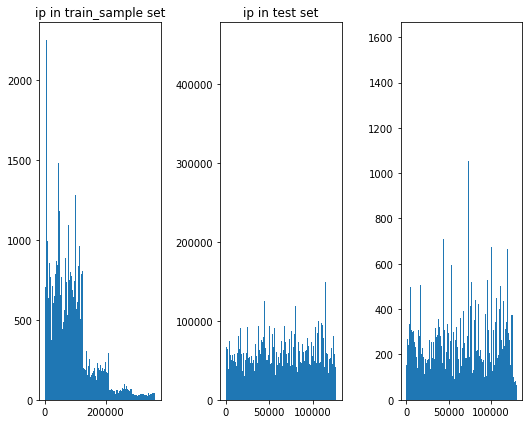

In [21]:
plt.subplot(1,3,1)
plt.hist(train_sample_no_dup_rows["ip"], bins = 300)
plt.title('ip in train_sample set')

plt.subplot(1,3,2)
plt.hist(test_no_dup_rows["ip"], bins = 300)
plt.title('ip in test set')

plt.subplot(1,3,3)
tsndrless = train_sample_no_dup_rows[train_sample_no_dup_rows.ip<130000]
plt.hist(tsndrless["ip"], bins = 300)
plt.title('ip in train_sample set with ip<130,000')

plt.tight_layout()
plt.show()

In [ ]:
# count the numbe of NaN's in the ip column.
print ("Number of NaN in ips", train_no_dup_rows["ip"].isnull().sum())

In [ ]:
# count number of ip duplicats
print ("Number of duplicated ip's are", train_no_dup_rows["ip"].duplicated().sum())

In [ ]:
# count number of ip's, how many times each is repeated.
ip_count = train_no_dup_rows["ip"].value_counts()

In [ ]:
print ("ip counts:")
print (ip_count.head(5))
print ()
print ("most repeated ip is {} which is repeated {} times".format(ip_count.index[0], ip_count.iloc[0]))

### device EDA

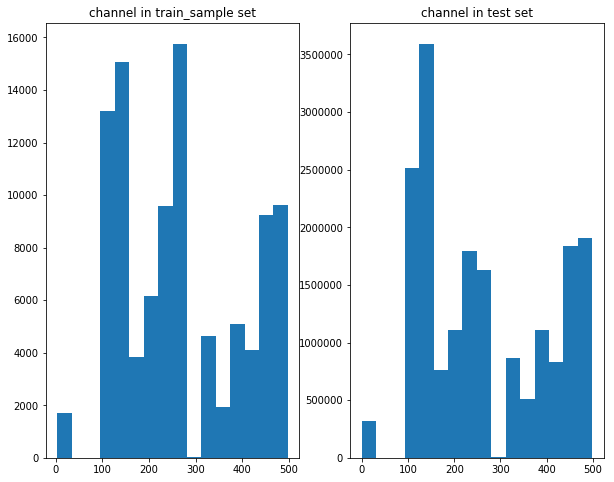

In [20]:
# sb.distplot(train_data["channel"])
plt.subplot(1,2,1)
plt.hist(train_sample_no_dup_rows["channel"], bins = 16)
plt.title('channel in train_sample set')


plt.subplot(1,2,2)
plt.hist(test_no_dup_rows["channel"], bins = 16)
plt.title('channel in test set')
plt.show()

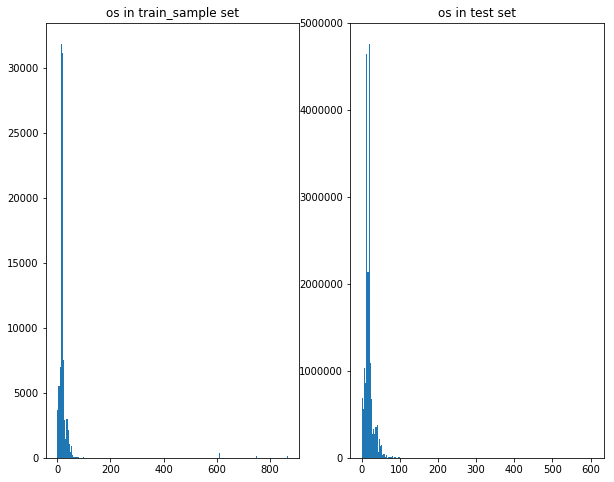

In [22]:
# sb.distplot(train_data_no_duplicate_rows["os"])
plt.subplot(1,2,1)
plt.hist(train_sample_no_dup_rows["os"], bins = 200)
plt.title('os in train_sample set')

plt.subplot(1,2,2)
plt.hist(test_no_dup_rows["os"], bins = 200)
plt.title('os in test set')
plt.show()

It seems some of the OS encodings provided by the company are too high. Perhaps they were missing and are replaced by random numbers. Lets investigate more:

In [30]:
np.sort(train_sample_no_dup_rows["os"].unique())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  52,  53,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  73,  74,  76,  77,  78,  79,  80,  81,  83,
        84,  85,  87,  88,  90,  92,  96,  97,  98,  99, 100, 102, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 127, 129,
       132, 133, 135, 137, 138, 142, 151, 152, 153, 155, 168, 172, 174,
       178, 184, 185, 192, 193, 196, 198, 199, 207, 607, 748, 836, 866])

In [126]:
print ("Number of data points with OS={} is {}".format(607, (len(train_sample_no_dup_rows[train_sample_no_dup_rows["os"]==607]))))
print ("Number of data points with OS={} is {}".format(748, (len(train_sample_no_dup_rows[train_sample_no_dup_rows["os"]==748]))))
print ("Number of data points with OS={} is {}".format(836, (len(train_sample_no_dup_rows[train_sample_no_dup_rows["os"]==836]))))
print ("Number of data points with OS={} is {}".format(866, (len(train_sample_no_dup_rows[train_sample_no_dup_rows["os"]==866]))))

Number of data points with OS=607 is 382
Number of data points with OS=748 is 166
Number of data points with OS=836 is 1
Number of data points with OS=866 is 115


In [60]:
A = train_no_dup_rows[(train_no_dup_rows.os>=600) & (train_no_dup_rows.os<=650)]
len(A)

710992

In [61]:
B = train_no_dup_rows[(train_no_dup_rows.os>=725) & (train_no_dup_rows.os<=788)]
len(B)

286256

In [62]:
C = train_no_dup_rows[(train_no_dup_rows.os>=850) & (train_no_dup_rows.os<=900)]
len(C)

201095

In [50]:
len(np.sort(train_no_dup_rows["os"].unique()))

800

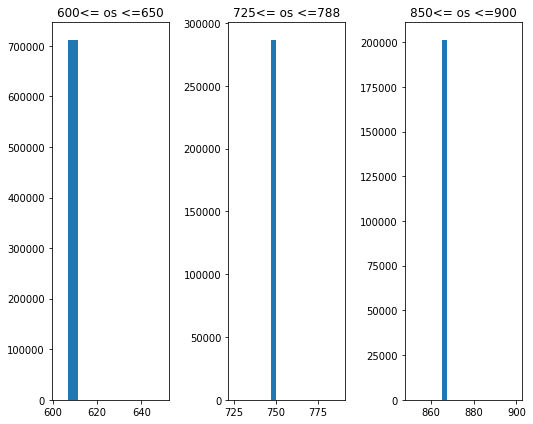

In [120]:
plt.subplot(1,3,1)
plt.hist(A["os"], bins = 10)
plt.title('600<= os <=650')

plt.subplot(1,3,2)
plt.hist(B["os"], bins = 20)
plt.title('725<= os <=788')

plt.subplot(1,3,3)
plt.hist(C["os"], bins = 20)
plt.title('850<= os <=900')
plt.tight_layout()
plt.show()

In [88]:
l1 = [None]*50
for ii in np.arange(600, 650):
    l1[ii-600] = len(A[A["os"]==ii])
print ("l1=", l1)

l1= [0, 0, 3, 54, 0, 0, 0, 710758, 2, 2, 6, 2, 2, 3, 37, 2, 3, 3, 1, 2, 2, 5, 6, 25, 6, 1, 1, 1, 2, 3, 1, 1, 1, 3, 5, 2, 1, 1, 1, 2, 5, 3, 2, 2, 1, 17, 1, 2, 3, 5]


In [86]:
l2 = [None]*63
for ii in np.arange(725, 788):
    l2[ii-725] = len(B[B["os"]==ii])
print ("l2=", l2)

l2= [2, 2, 2, 1, 2, 8, 1, 1, 4, 1, 3, 4, 2, 2, 3, 1, 1, 2, 3, 6, 2, 1, 4, 286076, 1, 2, 1, 3, 3, 1, 18, 2, 1, 3, 2, 1, 2, 5, 14, 4, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 9, 1, 13, 4, 2, 6, 1, 2, 1, 1, 3]


In [87]:
l3 = [None]*50
for ii in np.arange(850, 900):
    l3[ii-850] = len(C[C["os"]==ii])
print ("l3=", l3)

l3= [4, 1, 2, 2, 5, 3, 4, 5, 1, 1, 1, 1, 1, 4, 1, 1, 200981, 2, 4, 1, 3, 1, 1, 2, 3, 1, 3, 1, 1, 3, 1, 3, 4, 2, 3, 6, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 4, 3, 1, 2]


In [102]:
a = 2000
print ("No. of obs. in test  set with device code greater than {} is {}".format(a, len(test_no_dup_rows[test_no_dup_rows["device"]>a])))
print ("No. of obs. in train set with device code greater than {} is {}".format(a, len(train_no_dup_rows[train_no_dup_rows["device"]>a])))

No. of obs. in test  set with device code greater than 2000 is 767
No. of obs. in train set with device code greater than 2000 is 1140473


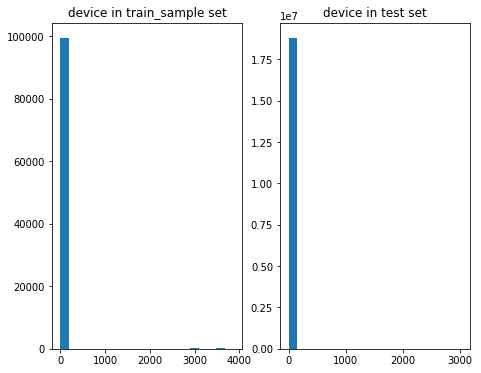

In [119]:
# sb.distplot(train_data["device"])
plt.subplot(1,2,1)
plt.hist(train_sample_no_dup_rows["device"], bins = 20)
plt.title('device in train_sample set')

plt.subplot(1,2,2)
plt.hist(test_no_dup_rows["device"], bins = 20)
plt.title('device in test set')
plt.show()

### Histograms of different features against target.


In [109]:
print ("Number of observations is {}".format(len(train_sample_no_dup_rows.is_attributed)))

print ("Number of observations that downloaded an app is {}".format(len(downloaded_by_os)))

Number of observations is 99999
Number of observations that downloaded an app is 227


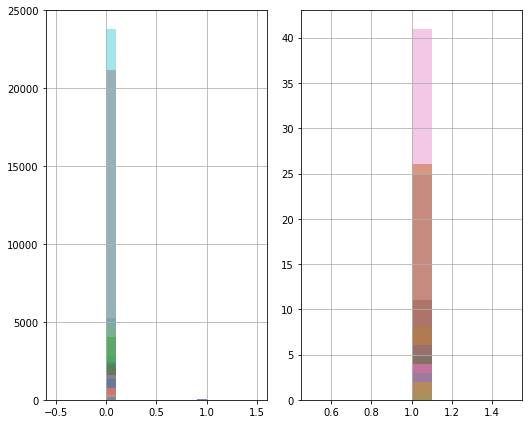

In [116]:
downloaded_by_os = train_sample_no_dup_rows[train_sample_no_dup_rows.is_attributed==1]

plt.subplot(1,2,1)
train_sample_no_dup_rows.groupby("os").is_attributed.hist(bins=10, alpha=0.4)

plt.subplot(1,2,2)
downloaded_by_os.groupby("os").is_attributed.hist(bins=10, alpha=0.4)
plt.tight_layout()
plt.show()

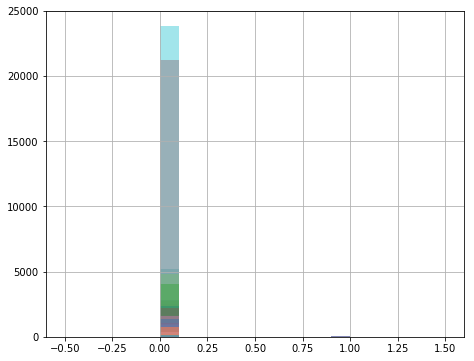

In [117]:
train_sample_no_dup_rows.groupby("os").is_attributed.hist(bins=10, alpha=0.4)
plt.show()

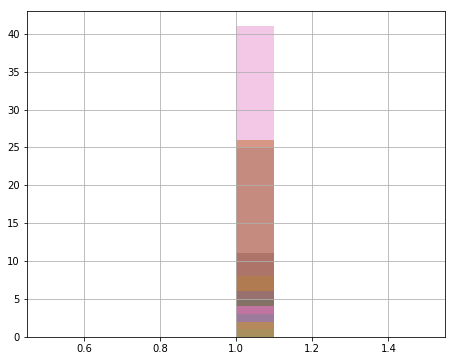

In [118]:
downloaded_by_os = train_sample_no_dup_rows[train_sample_no_dup_rows.is_attributed==1]
downloaded_by_os.groupby("os").is_attributed.hist(bins=10, alpha=0.4)
plt.show()

In [110]:
print ("Number of observations is {}".format(len(train_sample_no_dup_rows.is_attributed)))

print ("Number of observations that downloaded an app is {}".format(len(downloaded_by_device)))

Number of observations is 99999
Number of observations that downloaded an app is 227


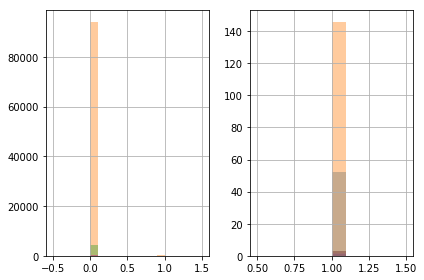

In [114]:
downloaded_by_device = train_sample_no_dup_rows[train_sample_no_dup_rows.is_attributed==1]

plt.subplot(1,2,1)
train_sample_no_dup_rows.groupby("device").is_attributed.hist(bins=10, alpha=0.4)

plt.subplot(1,2,2)
downloaded_by_os.groupby("device").is_attributed.hist(bins=10, alpha=0.4)

plt.tight_layout()
plt.show()

In [1]:
#train_sample_no_dup_rows.groupby("ip").is_attributed.hist(bins=100, alpha=0.4)
#plt.show()

In [19]:
#plt.hist(np.log(train_data["os"] + (10^-6)))
#plt.plot()

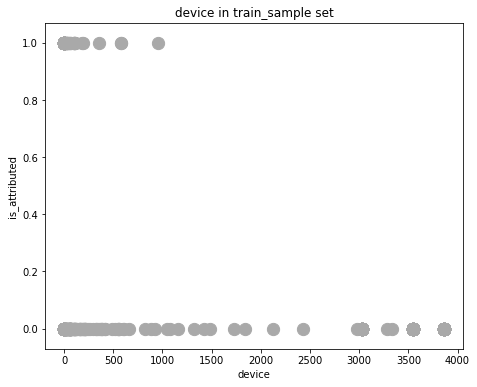

In [121]:
# sb.pairplot(train_data[], train_data[], palette='hls')
train_sample_no_dup_rows.plot(kind='scatter', x='device', y='is_attributed', c=['darkgray'], s=150)
plt.title('device in train_sample set')
plt.show()

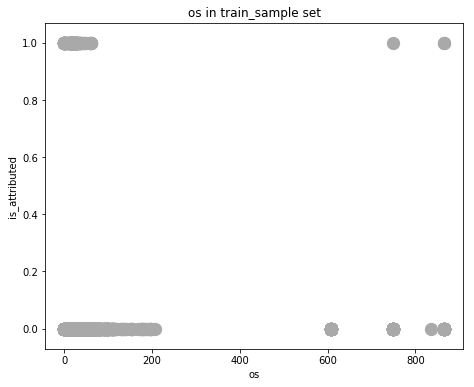

In [122]:
train_sample_no_dup_rows.plot(kind='scatter', x='os', y='is_attributed', c=['darkgray'], s=150)
plt.title('os in train_sample set')
plt.show()

# Educational
### [The Spearman Rank Correlation](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html), [Chi-square](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.chi2_contingency.html) test for independence


The [Chi-square](http://www.ling.upenn.edu/~clight/chisquared.htm) test is intended to test 
how likely it is that an observed distribution 
is due to chance. It is also called a "goodness of fit" statistic, 
because it measures how well the observed 
distribution of data fits with the distribution 
that is expected if the variables are independent. 

A Chi-square test is designed to analyze categorical data
e.g.
```python
cyl = cars['cyl']
vs = cars['vs']
am = cars['am']
gear = cars['gear']
spearmanr_coefficient, p_value = spearmanr(cyl, vs)
print 'Spearman Rank Correlation Coefficient %0.3f' % (spearmanr_coefficient)
```
e.g.
```python
table = pd.crosstab(cyl, am)
chi2, p, dof, expected = chi2_contingency(table.values)
print 'Chi-square Statistic %0.3f p_value %0.3f' % (chi2, p)
```

read more about [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) and [${\chi}^2$ test](https://en.wikipedia.org/wiki/Chi-squared_test)on wikipedia

In [ ]:
import scipy
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.stats.stats import pearsonr

### os correlation with target

In [ ]:
spearmanr_coefficient, p_value = spearmanr(train_sample_no_dup_rows["os"], train_no_dup_rows["is_attributed"])

In [ ]:
print ("spearmanr_coefficient={0:.{1}f}".format(spearmanr_coefficient, 6),",", "p_value={0:.{1}f}".format(p_value, 4))

### ip correlation with target

In [ ]:
spearmanr_coeff, p_value1 = spearmanr(train_sample_no_dup_rows["ip"], train_no_dup_rows["is_attributed"])

In [ ]:
print ("spearmanr_coefficient={0:.{1}f}".format(spearmanr_coeff, 6),",", "p_value={0:.{1}f}".format(p_value1, 4))

### os correlation with target

In [ ]:
pearsonr_coeff, p_val = pearsonr(train_sample_no_dup_rows["os"], train_no_dup_rows["is_attributed"])

In [ ]:
print ("PearsonR Correlation Coefficient={0:.{1}f}".format(pearsonr_coeff, 6),",", "p_value={0:.{1}f}".format(p_val, 4))